# Model Selection and Model Building

After Exploratory Data Analysis and Feature Selection, the features that should be fed to the model are:    

* Numerical:
    * age 
    * duration 
    * campaign 
    * previous 
    * cons.price.idx 
    * cons.conf.idx

* Categorical:
    * marital
    * default
    * job
    * contact
    * education
    * month
    * poutcome
    
* Target:
    * y : Imbalance of categorical target, This problem will be addressed when building the model using different methods:

        * Oversampling minority class
        * Alternative metric and/or loss function
        
## NOTE: The Feature Selection stage was carried out in the [EDA notebook](https://github.com/samuelcueva/Data-Glacier-Internship/blob/master/week%2010/EDA.ipynb)

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve


%matplotlib inline

In [2]:
import graphviz
import pydotplus

 ## Load Clean Dataset
 **This data set was pre-processed and serialized in EDA stage**

In [3]:
dataset = pd.read_pickle('../week 10/clean_dataset.pkl')
dataset

,age,job,marital,education,default,contact,month,duration,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,y
0,56,housemaid,married,basic.4y,no,telephone,may,5.568345,0.693147,0,nonexistent,93.994,-36.4,no
1,57,services,married,high.school,unknown,telephone,may,5.010635,0.693147,0,nonexistent,93.994,-36.4,no
2,37,services,married,high.school,no,telephone,may,5.424950,0.693147,0,nonexistent,93.994,-36.4,no
3,40,admin.,married,basic.6y,no,telephone,may,5.023881,0.693147,0,nonexistent,93.994,-36.4,no
4,56,services,married,high.school,no,telephone,may,5.730100,0.693147,0,nonexistent,93.994,-36.4,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41169,37,admin.,married,university.degree,no,cellular,nov,5.641907,0.693147,0,nonexistent,94.767,-50.8,yes
41170,29,unemployed,single,basic.4y,no,cellular,nov,4.727388,0.693147,1,success,94.767,-50.8,no
41172,46,blue-collar,married,professional.course,no,cellular,nov,5.950643,0.693147,0,nonexistent,94.767,-50.8,no
41173,56,retired,married,university.degree,no,cellular,nov,5.247024,1.098612,0,nonexistent,94.767,-50.8,no


In [4]:
dataset.nunique()

age                 54
job                 12
marital              3
education            7
default              2
contact              2
month               10
duration          1207
campaign            10
previous             8
poutcome             3
cons.price.idx      26
cons.conf.idx       26
y                    2
dtype: int64

### Imbalanced Target
As seen in EDA, the target has class imbalance.

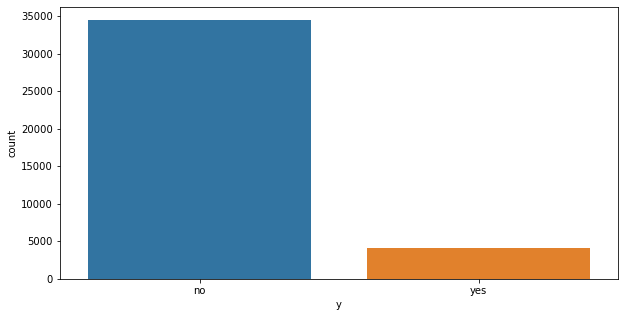

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='y',data=dataset,ax=ax)
plt.show()

In [6]:
cols = dataset.columns
num_cols = dataset._get_numeric_data().columns
numerical_att = list(num_cols) 
categorical_att = list(set(cols) - set(num_cols))
categorical_att


['default', 'education', 'y', 'contact', 'poutcome', 'month', 'job', 'marital']

In [7]:
numerical_att

['age', 'duration', 'campaign', 'previous', 'cons.price.idx', 'cons.conf.idx']

## Feature Engineering

### Preprocessing and Tranformation for Training


Categorical variables must be transformed into numeric variables to feed the machine learning model.


In [8]:
categorical_att.remove('y')
categorical_att

['default', 'education', 'contact', 'poutcome', 'month', 'job', 'marital']

### One-Hot Encoding


In [9]:
# to apply One-Hot Encoding to each categorical attribute
transformers = []
for att in categorical_att:
    transformers.append((att,OneHotEncoder(),[att]))

In [10]:
transformers

[('default', OneHotEncoder(), ['default']),
 ('education', OneHotEncoder(), ['education']),
 ('contact', OneHotEncoder(), ['contact']),
 ('poutcome', OneHotEncoder(), ['poutcome']),
 ('month', OneHotEncoder(), ['month']),
 ('job', OneHotEncoder(), ['job']),
 ('marital', OneHotEncoder(), ['marital'])]

In [11]:
ct = ColumnTransformer(transformers=transformers,remainder='passthrough')

dataset_ready = ct.fit_transform(dataset)
dataset_ready

array([[1.0, 0.0, 1.0, ..., 93.994, -36.4, 'no'],
       [0.0, 1.0, 0.0, ..., 93.994, -36.4, 'no'],
       [1.0, 0.0, 0.0, ..., 93.994, -36.4, 'no'],
       ...,
       [1.0, 0.0, 0.0, ..., 94.767, -50.8, 'no'],
       [1.0, 0.0, 0.0, ..., 94.767, -50.8, 'no'],
       [1.0, 0.0, 0.0, ..., 94.767, -50.8, 'yes']], dtype=object)

In [12]:
ct.get_feature_names()

['default__x0_no',
 'default__x0_unknown',
 'education__x0_basic.4y',
 'education__x0_basic.6y',
 'education__x0_basic.9y',
 'education__x0_high.school',
 'education__x0_professional.course',
 'education__x0_university.degree',
 'education__x0_unknown',
 'contact__x0_cellular',
 'contact__x0_telephone',
 'poutcome__x0_failure',
 'poutcome__x0_nonexistent',
 'poutcome__x0_success',
 'month__x0_apr',
 'month__x0_aug',
 'month__x0_dec',
 'month__x0_jul',
 'month__x0_jun',
 'month__x0_mar',
 'month__x0_may',
 'month__x0_nov',
 'month__x0_oct',
 'month__x0_sep',
 'job__x0_admin.',
 'job__x0_blue-collar',
 'job__x0_entrepreneur',
 'job__x0_housemaid',
 'job__x0_management',
 'job__x0_retired',
 'job__x0_self-employed',
 'job__x0_services',
 'job__x0_student',
 'job__x0_technician',
 'job__x0_unemployed',
 'job__x0_unknown',
 'marital__x0_divorced',
 'marital__x0_married',
 'marital__x0_single',
 'age',
 'duration',
 'campaign',
 'previous',
 'cons.price.idx',
 'cons.conf.idx',
 'y']

In [13]:
dataset_ready.shape

(38625, 46)

In [14]:
dataset_ready[:,-6]

array([5.568344503761097, 5.0106352940962555, 5.424950017481403, ...,
       5.950642552587727, 5.247024072160486, 6.093569770045136],
      dtype=object)

In [15]:
# Removing 'duration' attribute
dataset_ready = np.delete(dataset_ready,-6,axis=1)

In [16]:
dataset_ready[0,:]

array([1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
       56, 0.6931471805599453, 0, 93.994, -36.4, 'no'], dtype=object)

### Transform target from categorical to numerical

In [17]:
dataset_ready[:,-1] = np.where(dataset_ready[:,-1]=='yes',1,0)
dataset_ready[:,-1]

array([0, 0, 0, ..., 0, 0, 1], dtype=object)

In [18]:
dataset_ready = dataset_ready.astype('float64')
dataset_ready

array([[  1.   ,   0.   ,   1.   , ...,  93.994, -36.4  ,   0.   ],
       [  0.   ,   1.   ,   0.   , ...,  93.994, -36.4  ,   0.   ],
       [  1.   ,   0.   ,   0.   , ...,  93.994, -36.4  ,   0.   ],
       ...,
       [  1.   ,   0.   ,   0.   , ...,  94.767, -50.8  ,   0.   ],
       [  1.   ,   0.   ,   0.   , ...,  94.767, -50.8  ,   0.   ],
       [  1.   ,   0.   ,   0.   , ...,  94.767, -50.8  ,   1.   ]])

### Separate the attributes and the target

In [19]:
X = dataset_ready[:,:-1]
X

array([[  1.   ,   0.   ,   1.   , ...,   0.   ,  93.994, -36.4  ],
       [  0.   ,   1.   ,   0.   , ...,   0.   ,  93.994, -36.4  ],
       [  1.   ,   0.   ,   0.   , ...,   0.   ,  93.994, -36.4  ],
       ...,
       [  1.   ,   0.   ,   0.   , ...,   0.   ,  94.767, -50.8  ],
       [  1.   ,   0.   ,   0.   , ...,   0.   ,  94.767, -50.8  ],
       [  1.   ,   0.   ,   0.   , ...,   0.   ,  94.767, -50.8  ]])

In [20]:
y = dataset_ready[:,-1]
y

array([0., 0., 0., ..., 0., 0., 1.])

In [21]:
X.shape, y.shape, dataset_ready.shape

((38625, 44), (38625,), (38625, 45))

## Deal with data imbalance - SMOTE (Synthetic Minority Oversampling Technique)

### before SMOTE

In [22]:
total_ones = y.sum()

print('fraction of positive examples in training dataset: {:.2f}%'.format((total_ones/y.shape[0])*100))

fraction of positive examples in training dataset: 10.72%


In [23]:
X.shape,y.shape

((38625, 44), (38625,))

### SMOTE

In [24]:
sm = SMOTE(sampling_strategy=0.5)

X_over, y_over = sm.fit_resample(X,y)

total_ones = y_over.sum()

print('fraction of positive examples in training dataset: {:.2f}%'.format((total_ones/y_over.shape[0])*100))

fraction of positive examples in training dataset: 33.33%


### Split the dataset into Trainig and Test 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46551, 44), (5173, 44), (46551,), (5173,))

## Build Machine Learning model

### Base Model: Decision Tree

In [26]:
clf = DecisionTreeClassifier(min_samples_split=100)

# Training
clf.fit(X_train, y_train)


DecisionTreeClassifier(min_samples_split=100)

#### Metrics for Training set

In [27]:
train_predictions = clf.predict(X_train)
train_predictions

array([0., 0., 1., ..., 0., 0., 0.])

#### Confusion matrix

In [28]:


def plot_confusion_matrix(y_test,y_pred,labels):
    cm = confusion_matrix(y_test,y_pred,labels=labels)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix ')
    plt.ylabel('True label')
    plt.xlabel('Predictions')

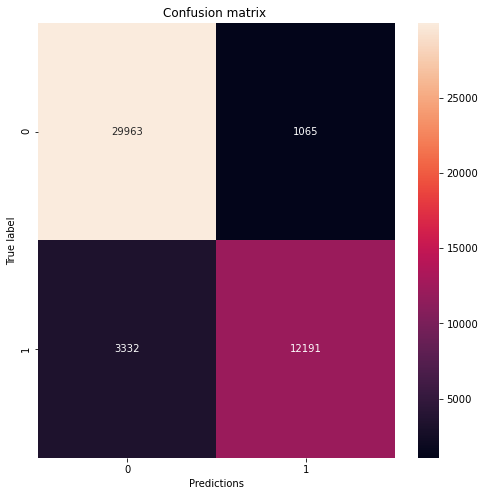

In [29]:
plot_confusion_matrix(y_train,train_predictions,labels=[0,1])

In [30]:
print(classification_report(y_train, train_predictions ))

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93     31028
         1.0       0.92      0.79      0.85     15523

    accuracy                           0.91     46551
   macro avg       0.91      0.88      0.89     46551
weighted avg       0.91      0.91      0.90     46551



#### Metrics for Test set

In [31]:
test_predictions = clf.predict(X_test)
test_predictions

array([0., 1., 0., ..., 1., 0., 1.])

#### Confusion Matrix

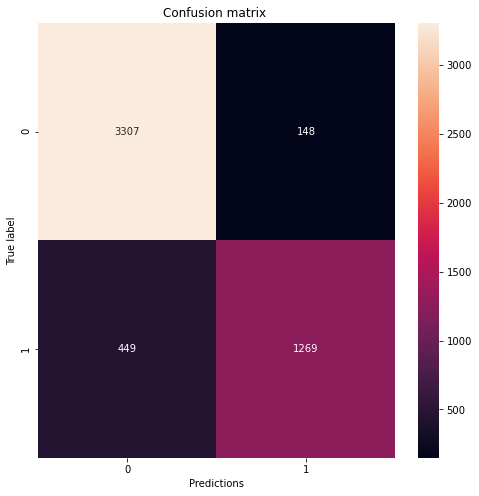

In [32]:
plot_confusion_matrix(y_test,test_predictions,labels=[0,1])

In [33]:
print(classification_report(y_test, test_predictions ))

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      3455
         1.0       0.90      0.74      0.81      1718

    accuracy                           0.88      5173
   macro avg       0.89      0.85      0.86      5173
weighted avg       0.89      0.88      0.88      5173



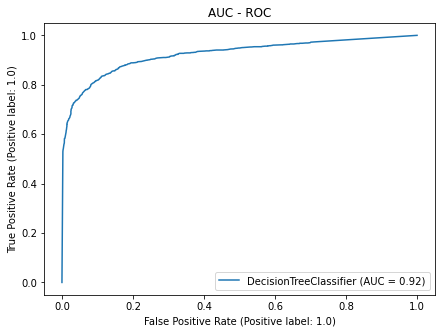

In [34]:
fig,ax = plt.subplots(figsize=(7,5))
plot_roc_curve(clf, X_test, y_test,ax=ax )
ax.set_title('AUC - ROC')
plt.show()

### Linear Model: Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver ='lbfgs',max_iter=5000 )

# Training
clf.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [36]:
test_predictions = clf.predict(X_test)
test_predictions

array([0., 1., 0., ..., 1., 0., 0.])

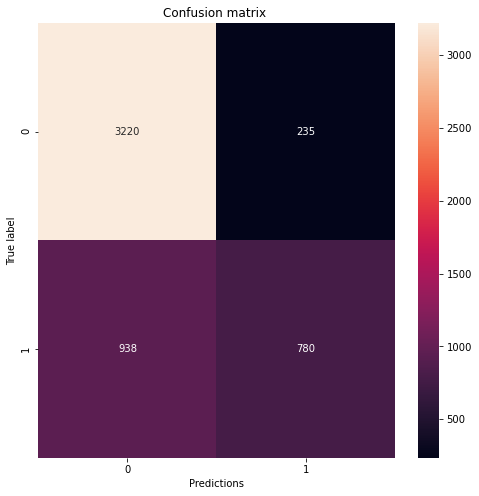

In [37]:
plot_confusion_matrix(y_test,test_predictions,labels=[0,1])

In [38]:
print(classification_report(y_test, test_predictions ))

              precision    recall  f1-score   support

         0.0       0.77      0.93      0.85      3455
         1.0       0.77      0.45      0.57      1718

    accuracy                           0.77      5173
   macro avg       0.77      0.69      0.71      5173
weighted avg       0.77      0.77      0.75      5173



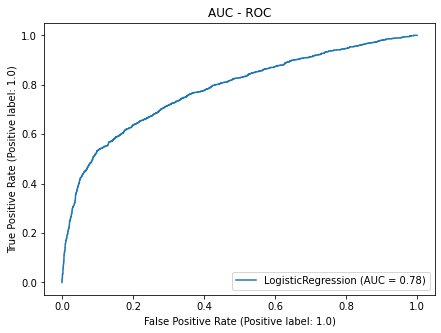

In [39]:
fig,ax = plt.subplots(figsize=(7,5))
plot_roc_curve(clf, X_test, y_test,ax=ax )
ax.set_title('AUC - ROC')
plt.show()

### Ensemble model: Random Forest

In [40]:
clf = RandomForestClassifier(n_estimators=2000,min_samples_split=200)
# Training
clf.fit(X_train, y_train )

RandomForestClassifier(min_samples_split=200, n_estimators=2000)

In [41]:
test_predictions = clf.predict(X_test)
test_predictions

array([0., 1., 0., ..., 1., 0., 1.])

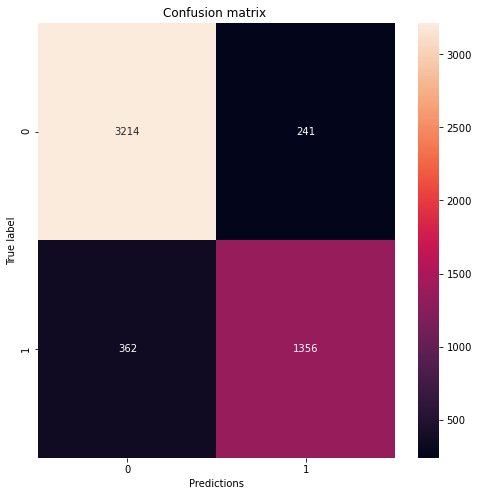

In [42]:
plot_confusion_matrix(y_test,test_predictions,labels=[0,1])

In [43]:
print(classification_report(y_test, test_predictions ))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      3455
         1.0       0.85      0.79      0.82      1718

    accuracy                           0.88      5173
   macro avg       0.87      0.86      0.87      5173
weighted avg       0.88      0.88      0.88      5173



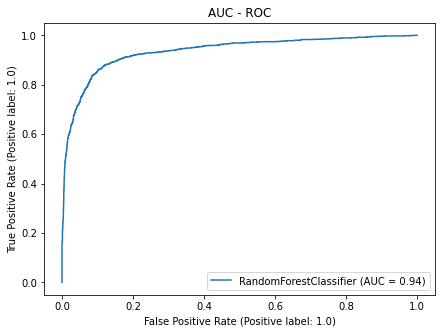

In [44]:
fig,ax = plt.subplots(figsize=(7,5))
plot_roc_curve(clf, X_test, y_test,ax=ax )
ax.set_title('AUC - ROC')
plt.show()

### Boosting model: XGBoost

In [45]:
import xgboost

In [46]:
clf = xgboost.XGBClassifier(n_estimators=1000,learning_rate=0.01,use_label_encoder=False)

In [47]:
#Training
clf.fit(X_train,y_train)

[13:05:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [48]:
test_predictions = clf.predict(X_test)
test_predictions

array([0, 1, 0, ..., 1, 0, 0])

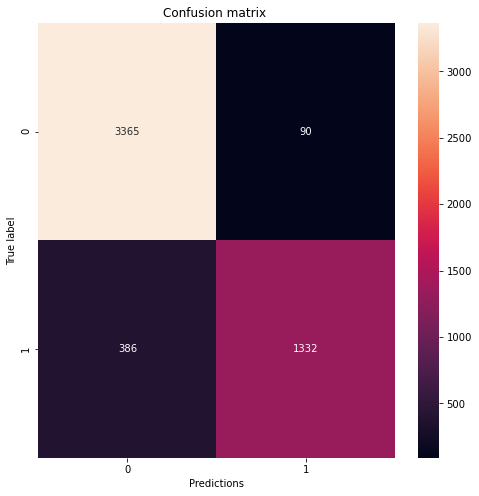

In [49]:
plot_confusion_matrix(y_test,test_predictions,labels=[0,1])

In [50]:
print(classification_report(y_test, test_predictions ))

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      3455
         1.0       0.94      0.78      0.85      1718

    accuracy                           0.91      5173
   macro avg       0.92      0.87      0.89      5173
weighted avg       0.91      0.91      0.91      5173



#### AUC -ROC 

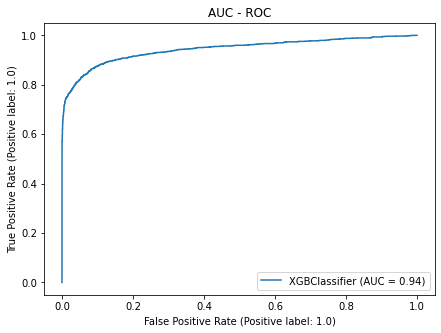

In [51]:
fig,ax = plt.subplots(figsize=(7,5))
plot_roc_curve(clf, X_test, y_test,ax=ax )
ax.set_title('AUC - ROC')
plt.show()

## Conclusions    

The better model will be evaluated with the **f1-score** and **AUC-ROC** metrics in the test set:

<table>
  <tr>
    <th>Model</th>
    <th>f1-score</th>
    <th>AUC-ROC</th>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>0.81</td>
    <td>0.92</td>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>0.57</td>
    <td>0.78</td>
  </tr>
      <tr>
    <td>Random Forest</td>
    <td>0.82</td>
    <td>0.94</td>
  </tr>
      <tr>
    <td>XGBoost</td>
    <td>0.85</td>
    <td>0.94</td>
  </tr>
</table>

Note: The **duration** attribute was not considered for these results